# Attention Distribution Plots

In [1]:
import os
from tqdm import tqdm

import e2cnn

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import PIL

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import configparser as ConfigParser

import utils
# Ipmport various network architectures
from networks import AGRadGalNet, DNSteerableLeNet, DNSteerableAGRadGalNet #e2cnn module only works in python3.7+
# Import various data classes
from datasets import FRDEEPF
from datasets import MiraBest_full, MBFRConfident, MBFRUncertain, MBHybrid
from datasets import MingoLoTSS, MLFR, MLFRTest

from sklearn.metrics import classification_report, roc_curve, auc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

## Attention Map Distributions

In [2]:
config_names = [
    "bowles2021mirabest.cfg",
    "bowles2021mirabest-RestrictedAug.cfg",
    "bowles2021mirabest-RandAug.cfg",
    
    "scaife2021mirabest.cfg",
    "scaife2021mirabest-RestrictedAug.cfg",
    "scaife2021mirabest-RandAug.cfg",
    
    "e2attentionmirabest.cfg",
    "e2attentionmirabest-RestrictedAug.cfg",
    "e2attentionmirabest-RandAug.cfg",
    
    "bowles2021mingo.cfg",
    "bowles2021mingo-RestrictedAug.cfg",
    "bowles2021mingo-RandAug.cfg",

    "scaife2021mingo.cfg", 
    "scaife2021mingo-RestrictedAug.cfg",
    "scaife2021mingo-RandAug.cfg",

    "e2attentionmingo.cfg",
    "e2attentionmingo-RestrictedAug.cfg",
    "e2attentionmingo-RandAug.cfg"
]

repititions = 36
cfg = config_names[-1]


# Read in Data Config
config_name = "configs/"+cfg
data_config = ConfigParser.ConfigParser(allow_no_value=True)
data_config.read(config_name)

# Read in Config
#cfg = config_names[2]
config_name = "configs/"+cfg
config = ConfigParser.ConfigParser(allow_no_value=True)
config.read(config_name)

# Load in model

path_supliment = config['data']['augment']
if path_supliment in ['True', 'False']:
    path_supliment=''
else:
    path_supliment+='/'

model = utils.utils.load_model(config, load_model='best', device=device, path_supliment=path_supliment)

# Load in data
test_data_loader = utils.data.load(data_config, train=False, augmentation='random rotation', data_loader=True)    # Prepare sources and labels
for idx, r in tqdm(enumerate(range(repititions))):
    for idy, (test_data, l) in enumerate(test_data_loader):
        # Produce Attention Maps
        amap_, amap_originals_ = utils.attention.attentions_func(
                test_data, 
                model,
                device=device,
                layer_no=3,
                layer_name_base='attention',
                mean=False
        )
        model.eval()
        raw_predictions_ = model(test_data.to(device))
        
        # Save data for analysis
        if idx+idy==0:
            sources = test_data.numpy()
            labels = np.asarray(l)
            raw_predictions = raw_predictions_.cpu().detach().numpy()
            amap = amap_
        else:
            sources = np.append(sources, test_data.numpy(), axis=0)
            labels = np.append(labels, np.asarray(l), axis=0)
            raw_predictions = np.append(raw_predictions, raw_predictions_.cpu().detach().numpy(), axis=0)
            amap = np.append(amap, amap_, axis=0)

predictions = raw_predictions.argmax(axis=1)

print(raw_predictions.shape)
print(labels.shape)
print(sources.shape)
print(amap.shape)
print(predictions.shape)

/raid/scratch/mbowles/EquivariantSelfAttention/venv/lib/python3.8/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:61: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  sampled_basis = sampled_basis[mask, ...]
/raid/scratch/mbowles/EquivariantSelfAttention/venv/lib/python3.8/site-packages/torchvision/transforms/transforms.py:1314: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  warnings.warn(


Files already downloaded and verified


0it [00:00, ?it/s]/raid/scratch/mbowles/EquivariantSelfAttention/venv/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
36it [09:26, 15.75s/it]

(8856, 2)
(8856,)
(8856, 1, 150, 150)
(8856, 3, 150, 150)
(8856,)


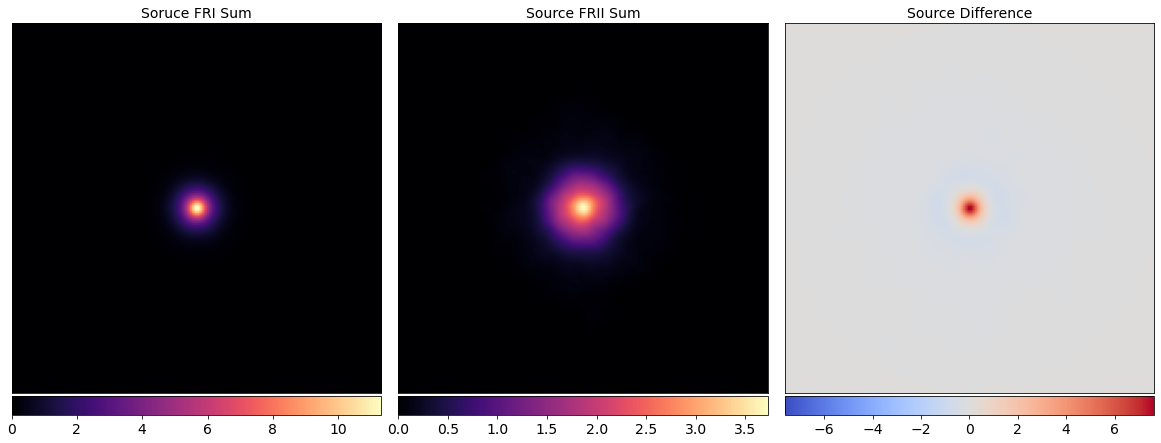

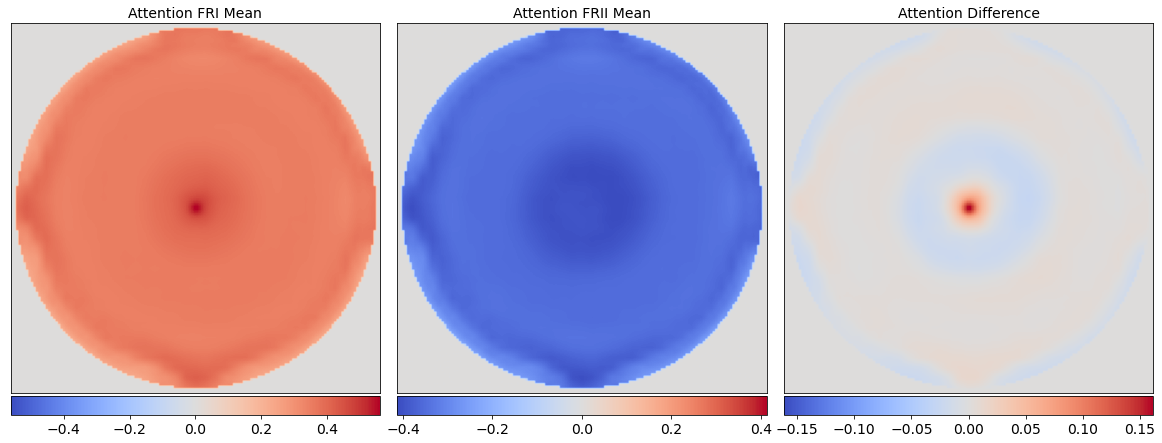

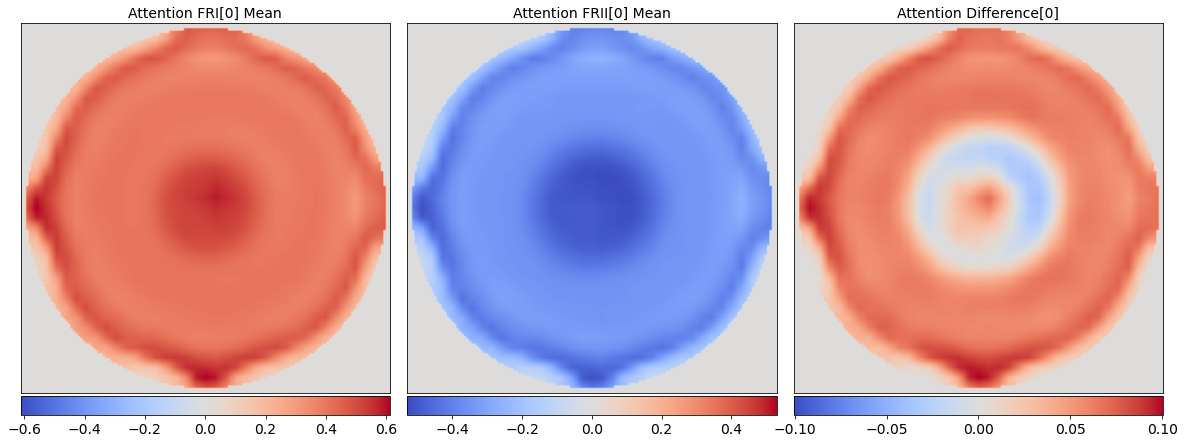

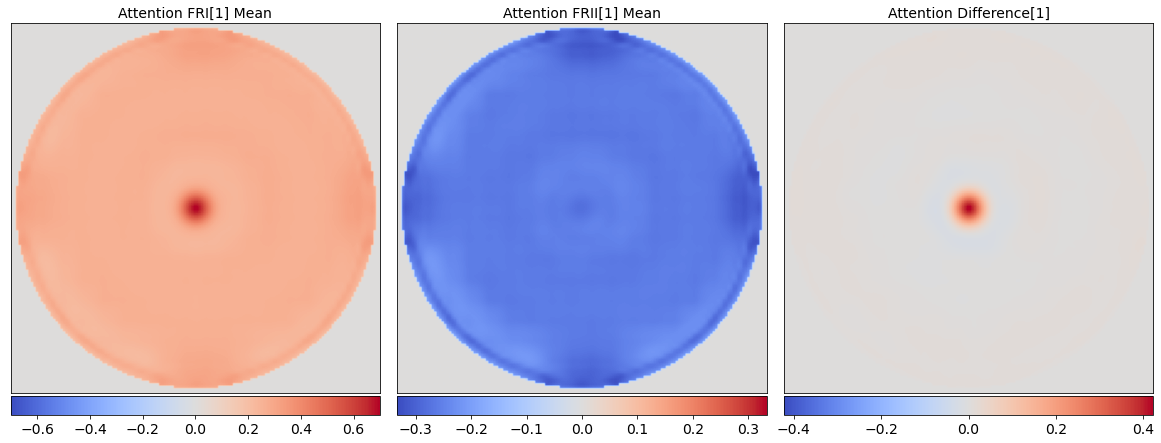

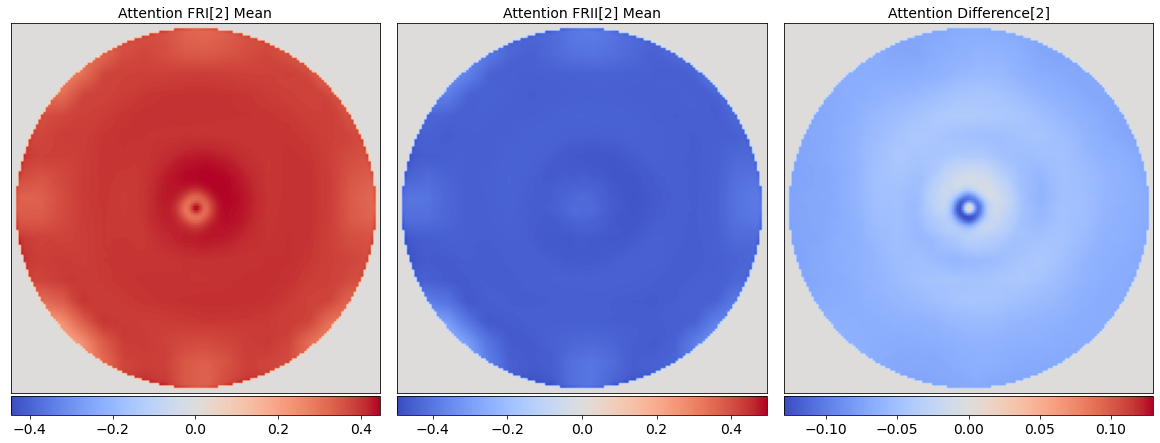

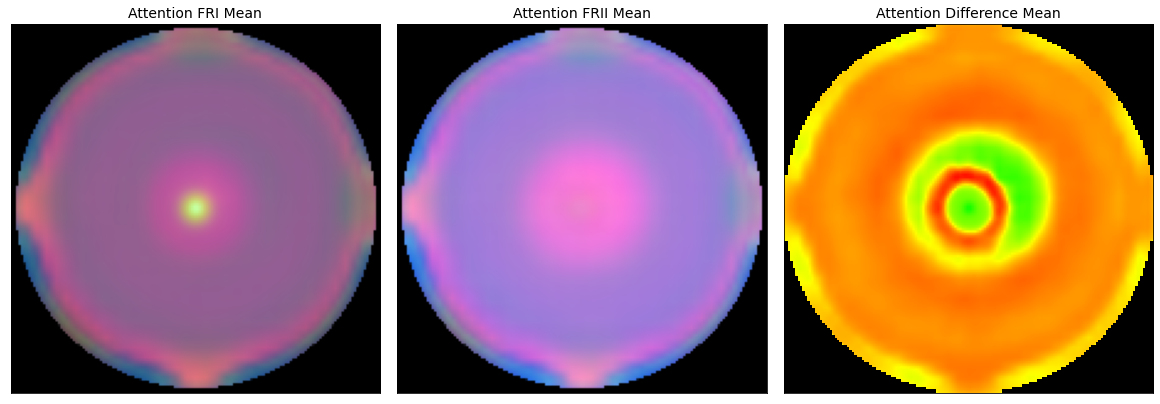

In [7]:
def sums_and_diff(a,b, mean=False):
    a_sum = a.sum(0)
    b_sum = b.sum(0)
    
    if mean:
        a_sum /= a.shape[0]
        b_sum /= b.shape[0]
    
    diff = a_sum-b_sum
    return a_sum, b_sum, diff

mask = utils.utils.build_mask(150).numpy().squeeze()

fri_sources = sources[np.where(labels==0)]
frii_sources= sources[np.where(labels==1)]

fri_amap = amap[np.where(labels==0)]
frii_amap= amap[np.where(labels==1)]

fri_source_sum, frii_source_sum, fr_source_diff = sums_and_diff(fri_sources, frii_sources, mean=True)
fri_amap_sum, frii_amap_sum, fr_amap_diff = sums_and_diff(fri_amap, frii_amap, mean=True)

# Source Differences
utils.utils.plot_3(
    fri_source_sum.squeeze()*mask, frii_source_sum.squeeze()*mask, fr_source_diff.squeeze()*mask, 
    cmaps=['magma', 'magma', 'coolwarm'], titles=["Soruce FRI Sum", "Source FRII Sum", "Source Difference"], 
    cbars_bool=[True], figsize=(16,9), factors=[1],
    vmin=[0, 0, 'adaptive'],
    vmax=['adaptive', 'adaptive', "adaptive"]
)

# Attention Map Differences
utils.utils.plot_3(
    fri_amap_sum.mean(0)*mask, frii_amap_sum.mean(0)*mask, fr_amap_diff.mean(0)*mask,
    cmaps=['coolwarm'], titles=["Attention FRI Mean", "Attention FRII Mean", "Attention Difference"],
    cbars_bool=[True], figsize=(16,9),
    vmin=['adaptive', 'adaptive', "adaptive"],
    vmax=['adaptive', 'adaptive', "adaptive"]
)
# Attention Map Differences by Gate
utils.utils.plot_3(
    fri_amap_sum[0]*mask,
    frii_amap_sum[0]*mask,
    fr_amap_diff[0]*mask,
    cmaps=['coolwarm'], 
    titles=["Attention FRI[0] Mean", "Attention FRII[0] Mean", "Attention Difference[0]"], 
    cbars_bool=[True], figsize=(16,9),
    vmin=['adaptive', 'adaptive', "adaptive"],
    vmax=['adaptive', 'adaptive', "adaptive"]
)
utils.utils.plot_3(
    fri_amap_sum[1]*mask,
    frii_amap_sum[1]*mask,
    fr_amap_diff[1]*mask,
    cmaps=['coolwarm'], 
    titles=["Attention FRI[1] Mean", "Attention FRII[1] Mean", "Attention Difference[1]"], 
    cbars_bool=[True], figsize=(16,9),
    vmin=['adaptive', 'adaptive', "adaptive"],
    vmax=['adaptive', 'adaptive', "adaptive"]
)
utils.utils.plot_3(
    fri_amap_sum[2]*mask,
    frii_amap_sum[2]*mask,
    fr_amap_diff[2]*mask,
    cmaps=['coolwarm'], 
    titles=["Attention FRI[2] Mean", "Attention FRII[2] Mean", "Attention Difference[2]"],
    cbars_bool=[True],
    figsize=(16,9),
    vmin=['adaptive', 'adaptive', "adaptive"],
    vmax=['adaptive', 'adaptive', "adaptive"]
)

# RGB Attention Map Differences
mask_ = np.expand_dims(mask, 2)
utils.utils.plot_3(
    fri_amap_sum.transpose(1,2,0)*mask_, 
    frii_amap_sum.transpose(1,2,0)*mask_, 
    fr_amap_diff.transpose(1,2,0)*mask_, 
    titles=["Attention FRI Mean", "Attention FRII Mean", "Attention Difference Mean"], 
    cbars_bool=[False], figsize=(16,9), factors=[1]
)

/raid/scratch/mbowles/EquivariantSelfAttention/utils/utils.py:100: RuntimeWarning: invalid value encountered in true_divide
  c = c/c.max(axis=2, keepdims=True)


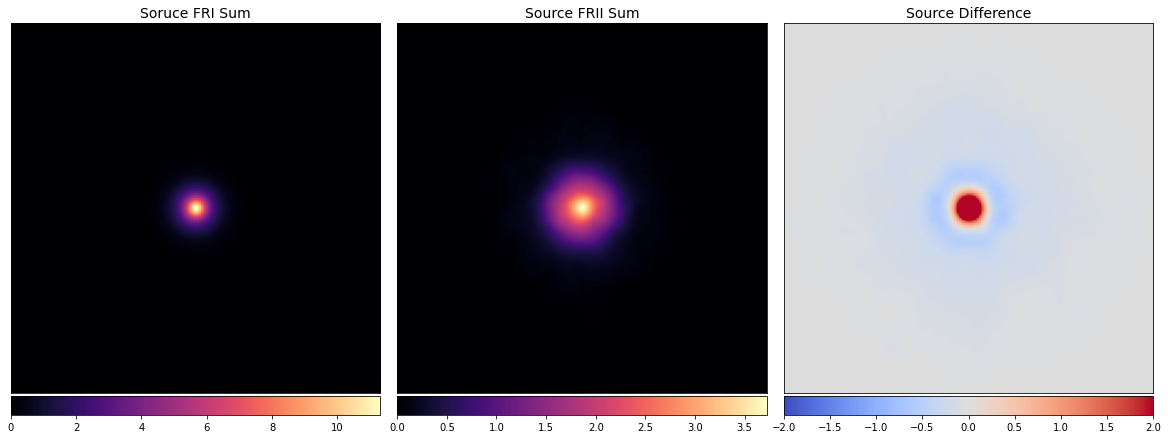

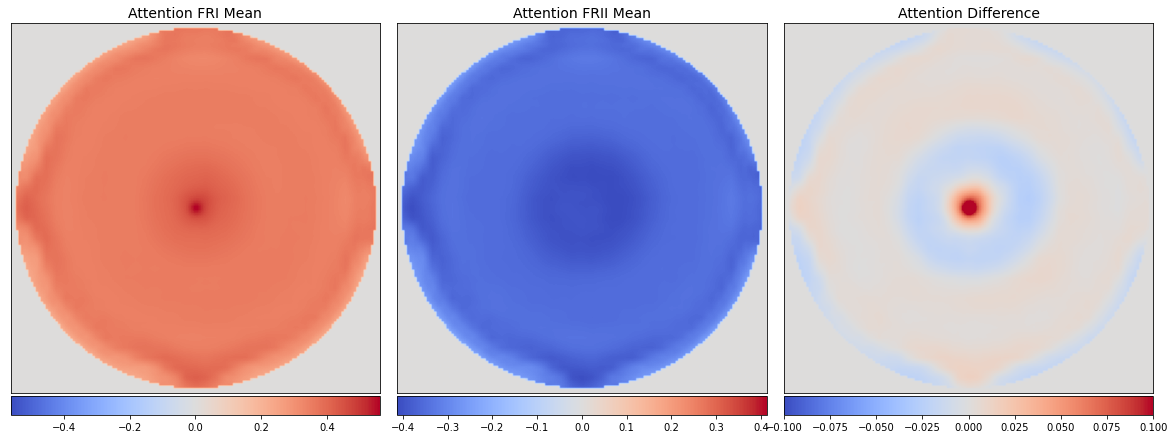

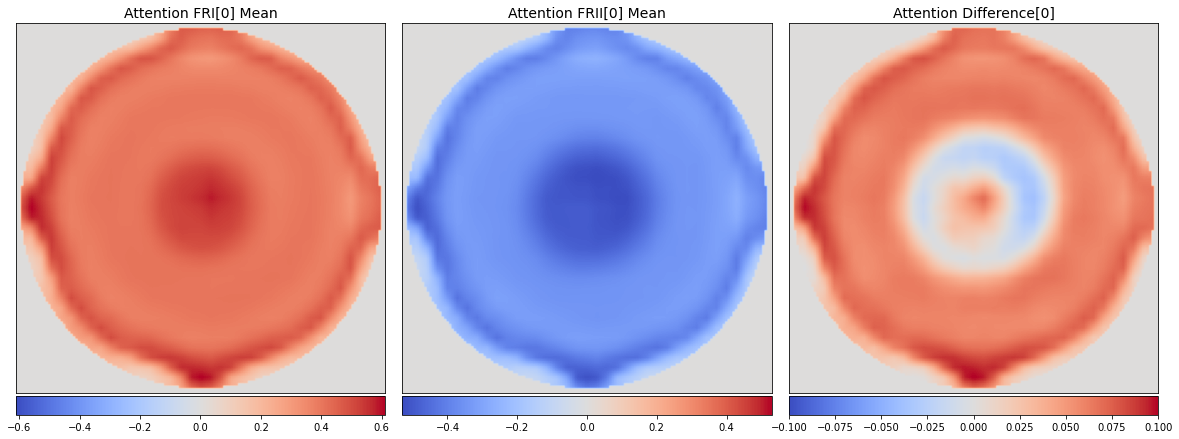

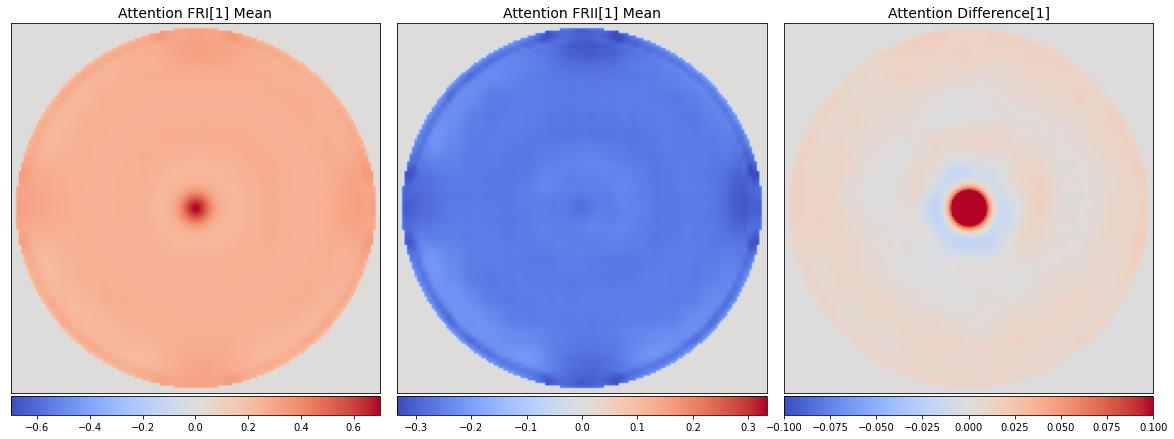

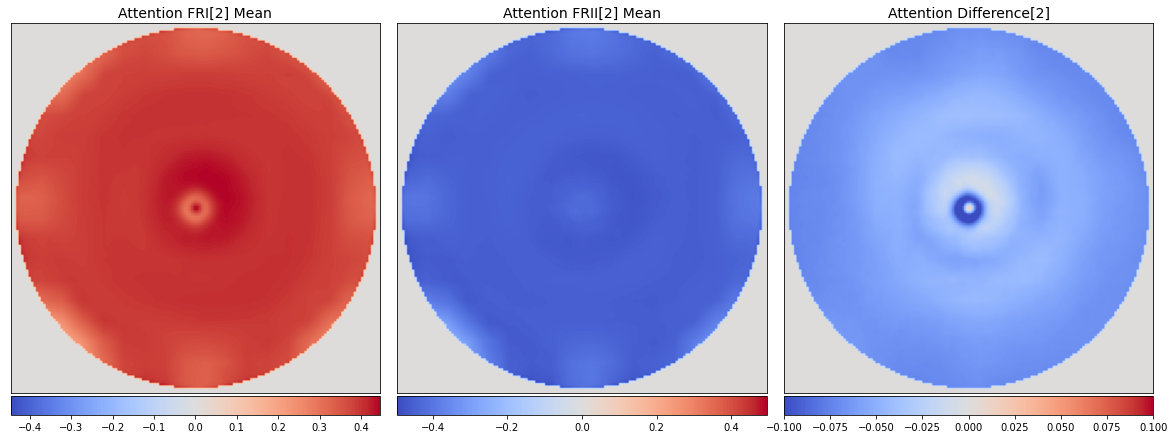

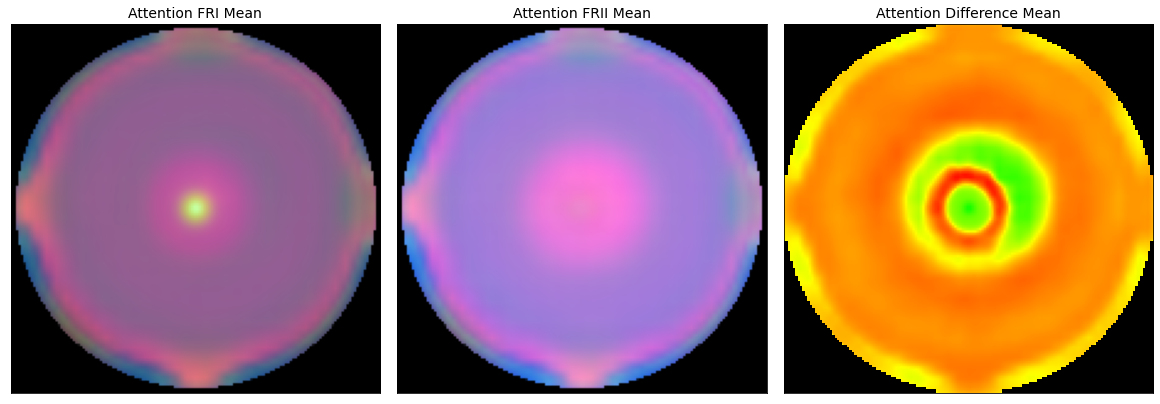

In [3]:
def sums_and_diff(a,b, mean=False):
    a_sum = a.sum(0)
    b_sum = b.sum(0)
    
    if mean:
        a_sum /= a.shape[0]
        b_sum /= b.shape[0]
    
    diff = a_sum-b_sum
    return a_sum, b_sum, diff

mask = utils.utils.build_mask(150).numpy().squeeze()

fri_sources = sources[np.where(labels==0)]
frii_sources= sources[np.where(labels==1)]

fri_amap = amap[np.where(labels==0)]
frii_amap= amap[np.where(labels==1)]

fri_source_sum, frii_source_sum, fr_source_diff = sums_and_diff(fri_sources, frii_sources, mean=True)
fri_amap_sum, frii_amap_sum, fr_amap_diff = sums_and_diff(fri_amap, frii_amap, mean=True)

# Source Differences
utils.utils.plot_3(
    fri_source_sum.squeeze()*mask, frii_source_sum.squeeze()*mask, fr_source_diff.squeeze()*mask, 
    cmaps=['magma', 'magma', 'coolwarm'], titles=["Soruce FRI Sum", "Source FRII Sum", "Source Difference"], 
    cbars_bool=[True], figsize=(16,9), factors=[1],
    vmin=[0, 0, 2],
    vmax=['adaptive', 'adaptive', 2]
)

# Attention Map Differences
utils.utils.plot_3(
    fri_amap_sum.mean(0)*mask, frii_amap_sum.mean(0)*mask, fr_amap_diff.mean(0)*mask,
    cmaps=['coolwarm'], titles=["Attention FRI Mean", "Attention FRII Mean", "Attention Difference"],
    cbars_bool=[True], figsize=(16,9),
    vmin=['adaptive', 'adaptive', 0.1],
    vmax=['adaptive', 'adaptive', 0.1]
)
# Attention Map Differences by Gate
utils.utils.plot_3(
    fri_amap_sum[0]*mask,
    frii_amap_sum[0]*mask,
    fr_amap_diff[0]*mask,
    cmaps=['coolwarm'], 
    titles=["Attention FRI[0] Mean", "Attention FRII[0] Mean", "Attention Difference[0]"], 
    cbars_bool=[True], figsize=(16,9),
    vmin=['adaptive', 'adaptive', 0.1],
    vmax=['adaptive', 'adaptive', 0.1]
)
utils.utils.plot_3(
    fri_amap_sum[1]*mask,
    frii_amap_sum[1]*mask,
    fr_amap_diff[1]*mask,
    cmaps=['coolwarm'], 
    titles=["Attention FRI[1] Mean", "Attention FRII[1] Mean", "Attention Difference[1]"], 
    cbars_bool=[True], figsize=(16,9),
    vmin=['adaptive', 'adaptive', 0.1],
    vmax=['adaptive', 'adaptive', 0.1]
)
utils.utils.plot_3(
    fri_amap_sum[2]*mask,
    frii_amap_sum[2]*mask,
    fr_amap_diff[2]*mask,
    cmaps=['coolwarm'], 
    titles=["Attention FRI[2] Mean", "Attention FRII[2] Mean", "Attention Difference[2]"],
    cbars_bool=[True],
    figsize=(16,9),
    vmin=['adaptive', 'adaptive', 0.1],
    vmax=['adaptive', 'adaptive', 0.1]
)

# RGB Attention Map Differences
mask_ = np.expand_dims(mask, 2)
utils.utils.plot_3(
    fri_amap_sum.transpose(1,2,0)*mask_, 
    frii_amap_sum.transpose(1,2,0)*mask_, 
    fr_amap_diff.transpose(1,2,0)*mask_, 
    titles=["Attention FRI Mean", "Attention FRII Mean", "Attention Difference Mean"], 
    cbars_bool=[False], figsize=(16,9), factors=[1]
)

In [4]:
TP = amap[np.where((labels==0) & (predictions==0))]
FN = amap[np.where((labels==0) & (predictions==1))]
FP = amap[np.where((labels==1) & (predictions==0))]
TN = amap[np.where((labels==1) & (predictions==1))]

source_TP = sources[np.where((labels==0) & (predictions==0))]
source_FN = sources[np.where((labels==0) & (predictions==1))]
source_FP = sources[np.where((labels==1) & (predictions==0))]
source_TN = sources[np.where((labels==1) & (predictions==1))]

In [5]:
def confusion_matrix_imgs(matrix, mask=False, RGB=False, cmap='magma', log=False):
    plt.rcParams.update({'font.size': 14})

    title = f'Confussion Matrix'
    classes = ['FRI','FRII']
    xticks_rotation='horizontal'
    temp = np.asarray(matrix)

    # Initialise figure
    fig, ax = plt.subplots(figsize=(8,8))
    
    im = matrix*mask if type(mask)==np.ndarray else matrix
    im = im.mean(axis=2) if not RGB else im
    im = np.log(im) if log else im
    img = ax.imshow(
        im, 
        interpolation='nearest', 
        origin='upper', 
        cmap=cmap,
        vmin=matrix.mean(axis=2).min()
    )
    
    ax.set(
        xticks=[75, 225],
        yticks=[75, 225],
        xticklabels=classes,
        yticklabels=classes,
        ylabel="True Label",
        xlabel="Predicted Label"
    )
    plt.setp(ax.get_xticklabels(), rotation=xticks_rotation)
    
    if not RGB:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(img, cax=cax, orientation='vertical')
    
    plt.show()

[[5835  645]
 [1329 1047]]


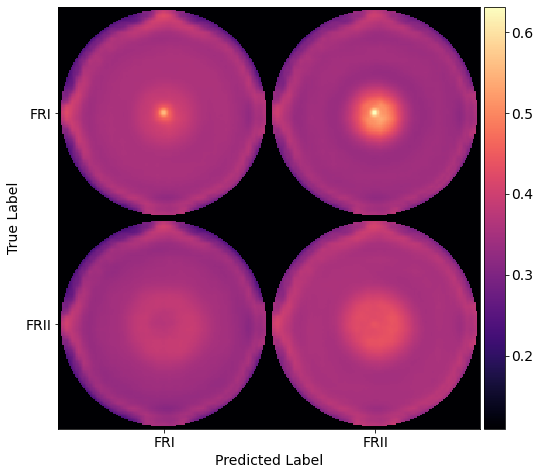

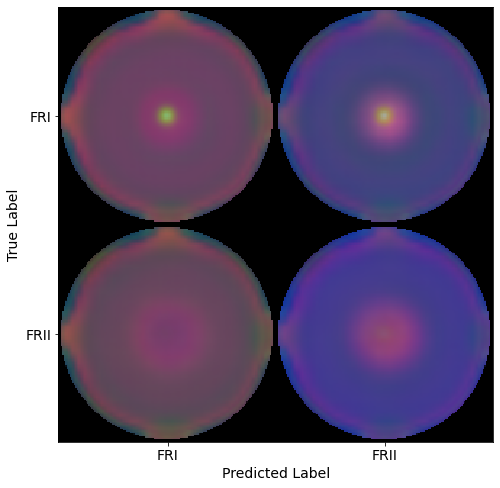

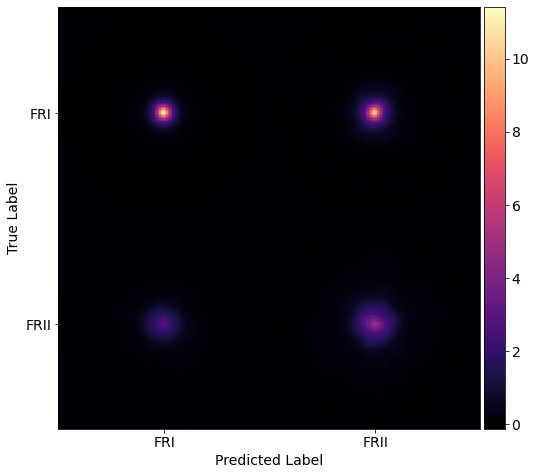

In [6]:
matrix = np.zeros((300,300,3))
source_matrix = np.zeros((300,300,3))

confussion_matrix = np.zeros((2,2))

mask = utils.utils.build_mask(150).numpy().squeeze()
mask = np.expand_dims(mask, 2)
mask2 = matrix.copy()
mask2[:150, :150] = mask
mask2[:150, 150:] = mask
mask2[150:, :150] = mask
mask2[150:, 150:] = mask

confussion_matrix = np.asarray([
    [TP.shape[0], FN.shape[0]],
    [FP.shape[0], TN.shape[0]]
])

print(confussion_matrix)

matrix[:150, :150] += TP.mean(axis=0).transpose(1,2,0)
matrix[:150, 150:] += FN.mean(axis=0).transpose(1,2,0)
matrix[150:, :150] += FP.mean(axis=0).transpose(1,2,0)
matrix[150:, 150:] += TN.mean(axis=0).transpose(1,2,0)

source_matrix[:150, :150] += source_TP.mean(axis=0).transpose(1,2,0)
source_matrix[:150, 150:] += source_FN.mean(axis=0).transpose(1,2,0)
source_matrix[150:, :150] += source_FP.mean(axis=0).transpose(1,2,0)
source_matrix[150:, 150:] += source_TN.mean(axis=0).transpose(1,2,0)

confusion_matrix_imgs(matrix, mask2, RGB=False, cmap='magma')
confusion_matrix_imgs(matrix, mask2, RGB=True, cmap='magma')
confusion_matrix_imgs(source_matrix, mask2, RGB=False, cmap='magma', log=False)

### Attention Map by Epoch

Files already downloaded and verified
models/e2attention/mirabest
torch.Size([5, 1, 150, 150])
Source images followed by their respective averaged attention maps at epochs:
[0, 383, 509, 591, 720, 1376]


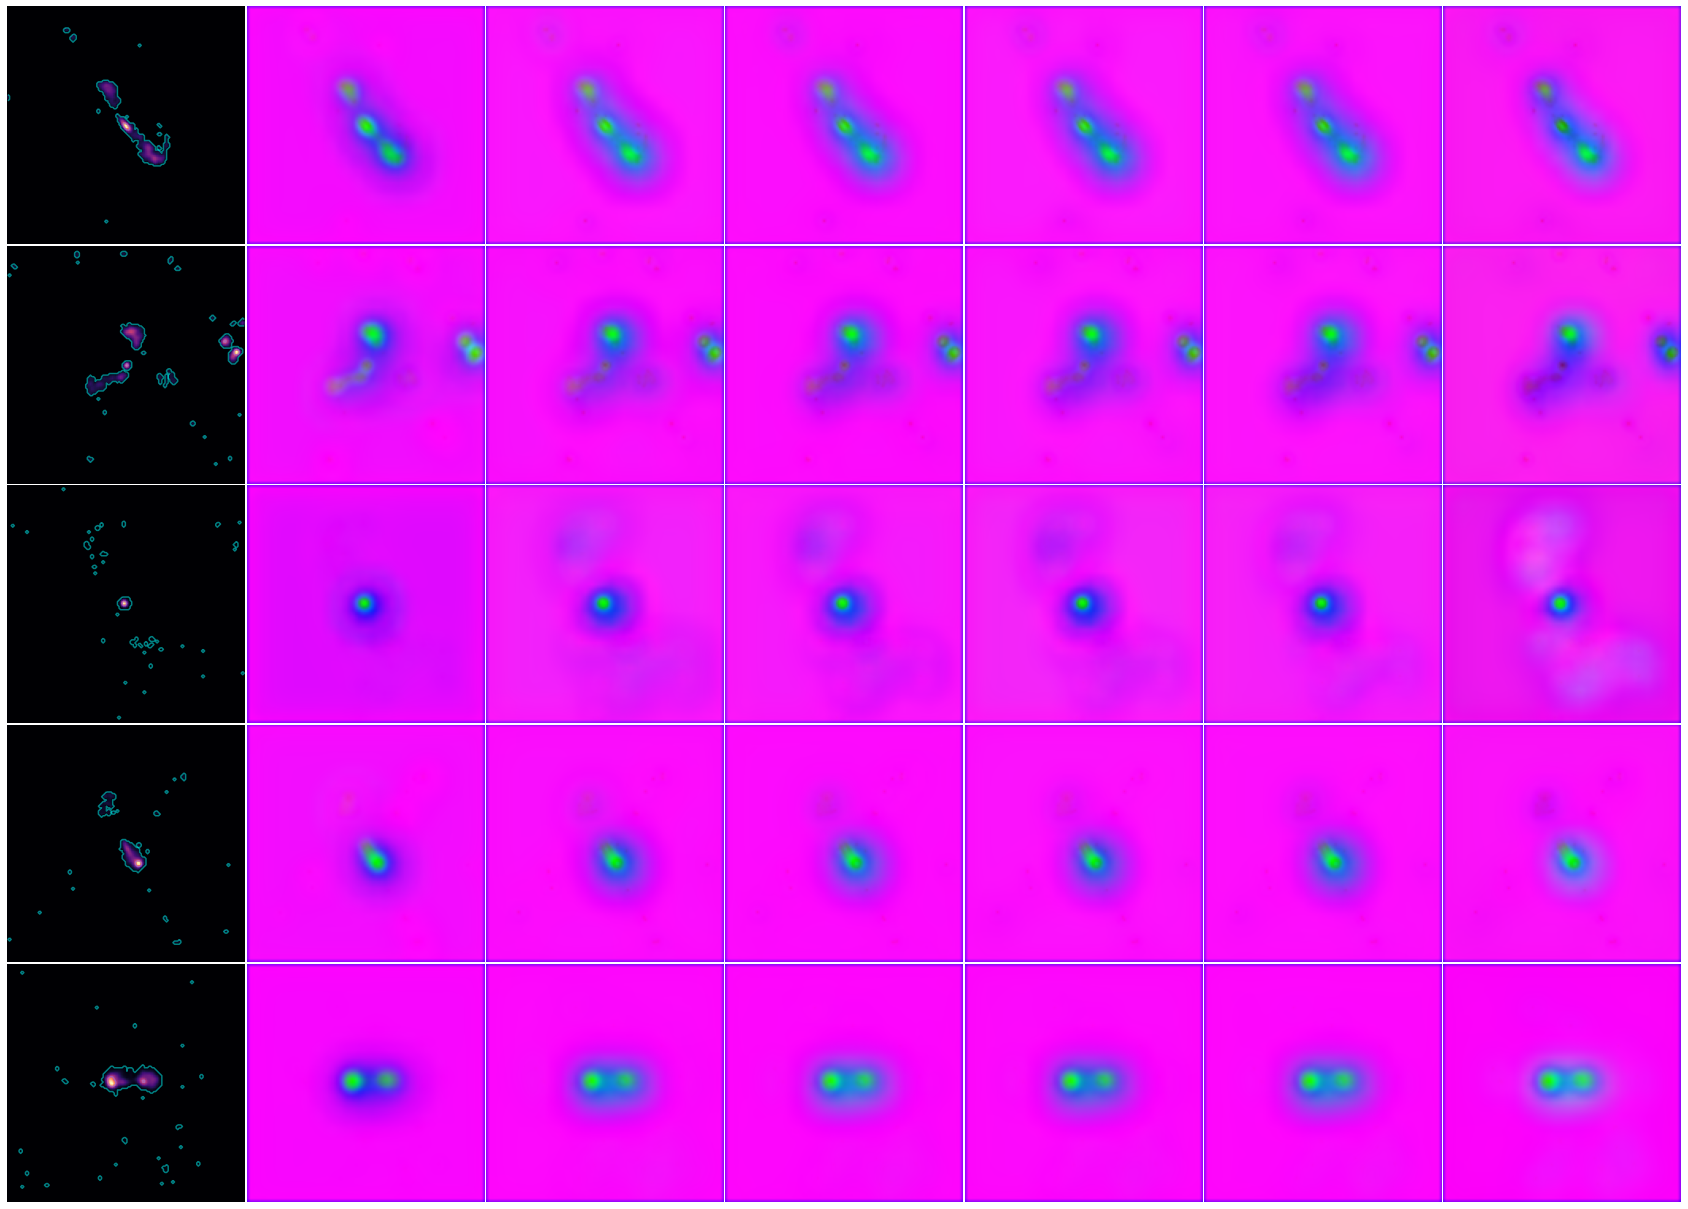

In [8]:
config_names = [
    #"bowles2021mirabest.cfg",
    #"e2attentionmirabest.cfg",
    
    #"bowles2021mingo.cfg",
    #"e2attentionmingo.cfg",
    
    "e2attentionmirabest-RandAug.cfg",
]

for cfg in config_names:
    config_name = "configs/"+cfg
    config = ConfigParser.ConfigParser(allow_no_value=True)
    config.read(config_name)

    # Load in model and data
    model = utils.utils.load_model(config, load_model='best', device=device)
    test_data = utils.data.load(config, train=False, augmentation='None', data_loader=False)

    # Extract attention map
    sources = test_data.data.transpose(0,3,1,2)
    
    # Attention by Epoch
    source_idxs = [3, 4, 5, 7, 9, 10, 17, 18, 22, 29]
    source_idxs = [3, 10, 18, 47, 48]
    first = True
    for idx, img in enumerate(sources):
        if idx in source_idxs:
            if first:
                first = False
                sources_ = torch.Tensor(img).view(-1,1,150,150)
            else:
                sources_ = torch.cat((sources_, torch.Tensor(img).view(-1,1,150,150)), dim=0)

    path_supliment = ''
    folder_name = config['output']['directory']
    print(folder_name)
    print(sources_.shape)

    # Change 'width' to see more of the development
    utils.attention.attention_epoch_plot(
        model,
        folder_name+path_supliment,
        sources_,
        width=6,
        device=device,
        layer_name_base='attention',
        layer_no=3,
        cmap_name='RGB',
        figsize=(30, 30)
    )

## Attention Maps for Selected Sources

In [13]:
def source_attention(
    config, 
    plot=None, 
    path_supliment='', 
    fontsize=14, 
    mean=True,
    RGB=False,
    device=torch.device('cpu')):
    """Plot attention maps for test set sources.
    """
    # Load in model and data
    model = utils.utils.load_model(config, load_model='best', device=device)
    test_data = utils.data.load(config, train=False, augmentation='None', data_loader=False)
    
    # Extract attention map
    sources = test_data.data.transpose(0,3,1,2)
    labels = np.asarray(test_data.targets)
    if RGB:
        mean_tmp = False
    else:
        mean_tmp = mean
    amap, amap_originals = utils.attention.attentions_func(
        sources, 
        model, 
        device=device, 
        layer_no=3, 
        layer_name_base='attention', 
        mean=mean_tmp)
    predictions=None
    
    plt.rcParams.update({'font.size': fontsize})
    # Plot sources
    if type(plot)==list:
        source_nos = plot
    elif plot=='all':
        source_nos = list(range(sources.shape[0]))
    
    if plot != None:
        sources = test_data.data.squeeze()
        source_nos.sort()
        for idx in source_nos:
            source = sources[idx]/255
            amap_   = amap[idx]
            amap_37 = amap_originals[idx*3+0]
            amap_75 = amap_originals[idx*3+1]
            amap_150 = amap_originals[idx*3+2]
            if RGB:
                amap_ = amap_.transpose(1,2,0)
                tmp = np.zeros((3, 150, 150))
                tmp37 = np.zeros((37, 37))
                tmp75 = np.zeros((75, 75))
                tmp150 = np.zeros((150, 150))
                amap_37 = np.stack((amap_37.squeeze(), tmp37, tmp37), axis=2)
                amap_75 = np.stack((tmp75, amap_75.squeeze(), tmp75), axis=2)
                amap_150 = np.stack((tmp150, tmp150, amap_150.squeeze()), axis=2) 

            plt.figure(figsize=(20,10))
            plt.tight_layout()

            plt.subplot(151)
            plt.title(f"Test Image {idx}")
            plt.imshow(source, origin='lower', cmap='magma',vmax=1,vmin=0)
            plt.contour(sources[idx], 1, cmap='cool', alpha=0.5)
            plt.xticks([])
            plt.yticks([])

            plt.subplot(152)
            plt.title(f"Averaged Attention")
            plt.imshow(amap_, origin='lower', cmap='magma', vmax=1,vmin=0)
            plt.xticks([])
            plt.yticks([])

            plt.subplot(153)
            plt.title(f"1st Attention Gate")
            plt.imshow(amap_37, origin='lower', cmap='magma', vmax=1,vmin=0)
            plt.yticks([])

            plt.subplot(154)
            plt.title(f"2nd Attention Gate")
            plt.imshow(amap_75, origin='lower', cmap='magma', vmax=1,vmin=0)
            plt.yticks([])

            plt.subplot(155)
            plt.title(f"3rd Attention Gate")
            plt.imshow(amap_150, origin='lower', cmap='magma', vmax=1,vmin=0)
            plt.yticks([])
            
            plt.show()
        
    return amap, amap_originals, test_data, predictions

configs/e2attentionmirabest.cfg
Files already downloaded and verified


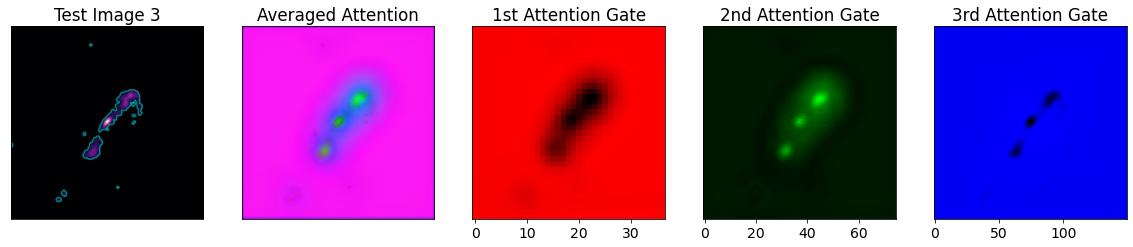

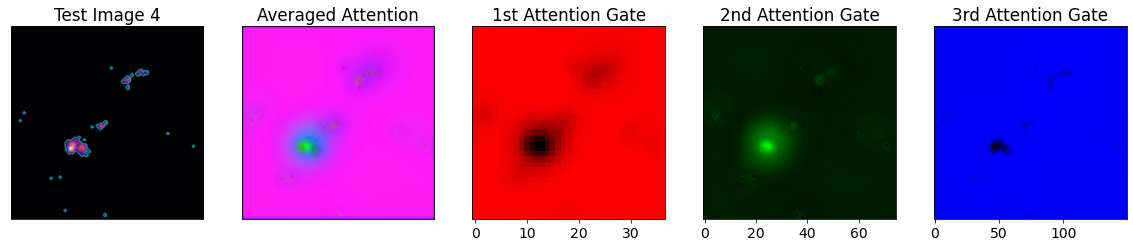

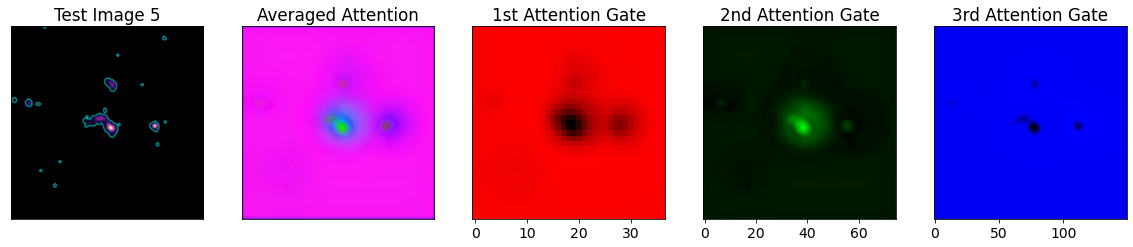

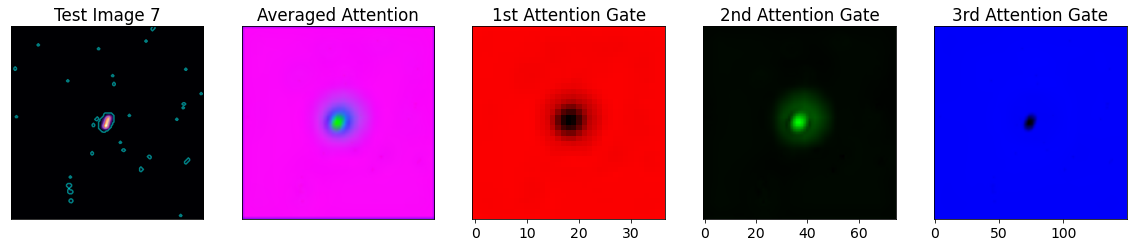

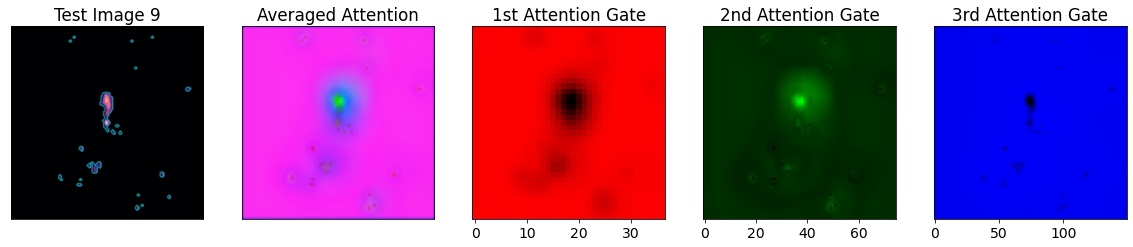

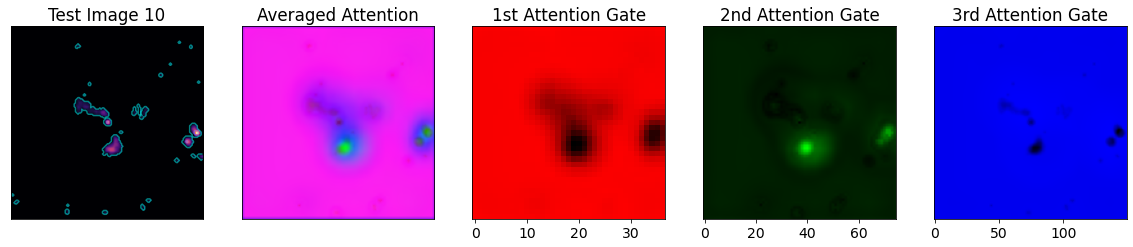

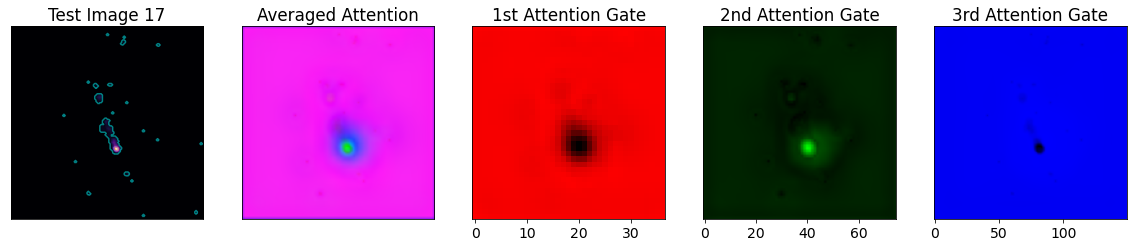

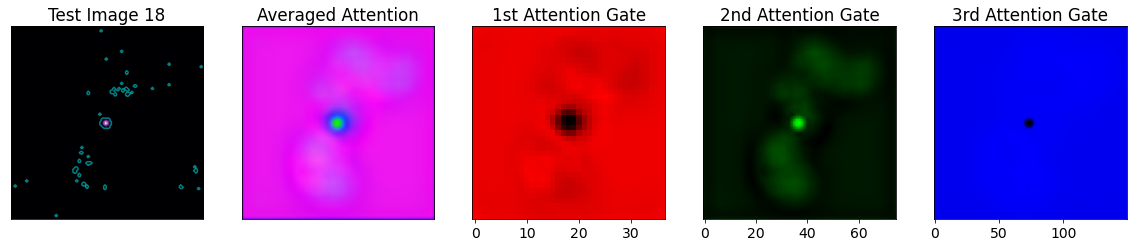

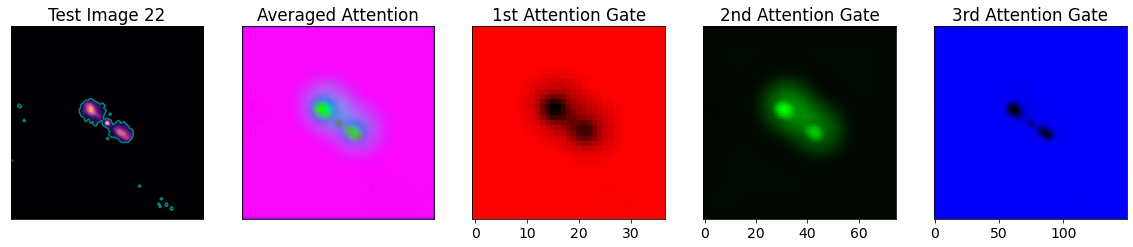

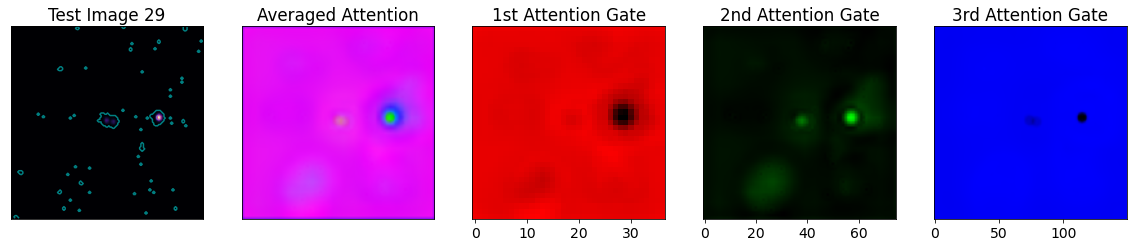

configs/e2attentionmingo.cfg
Files already downloaded and verified


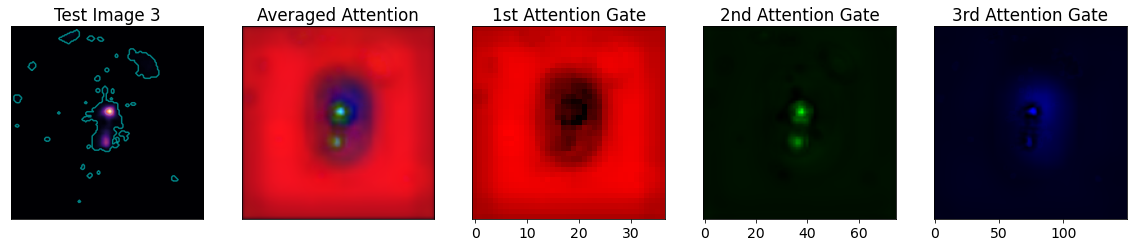

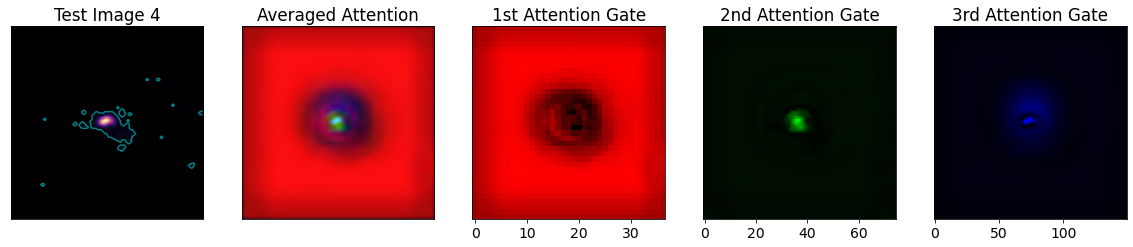

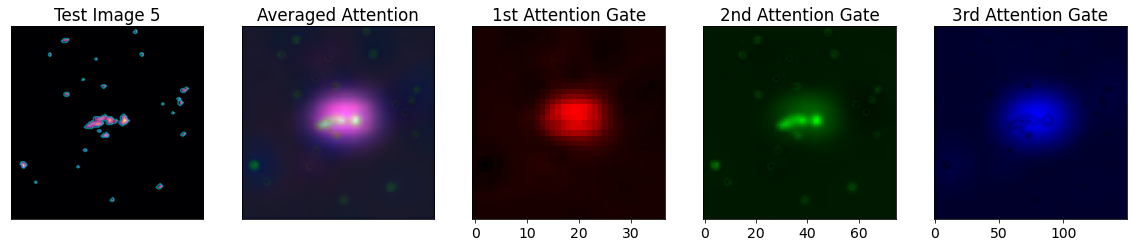

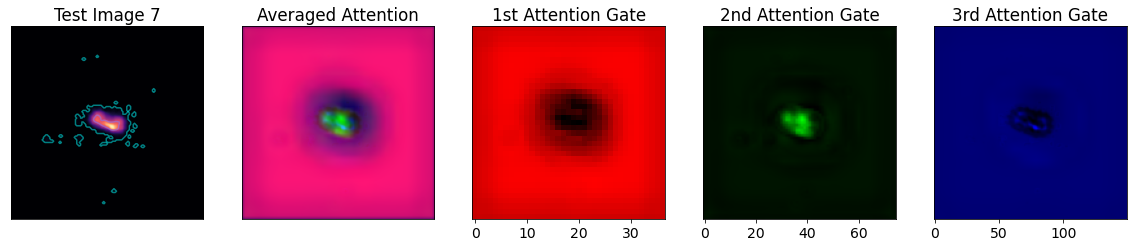

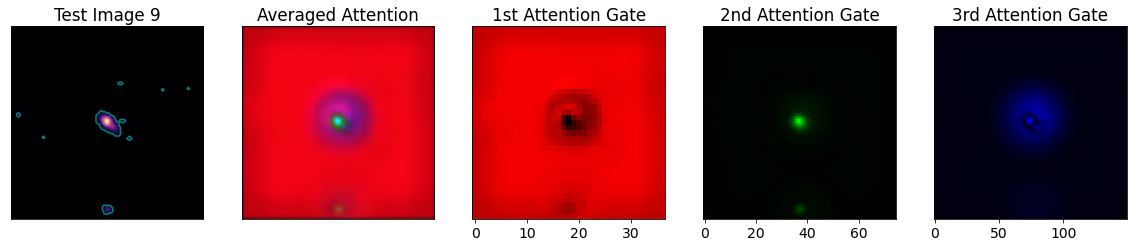

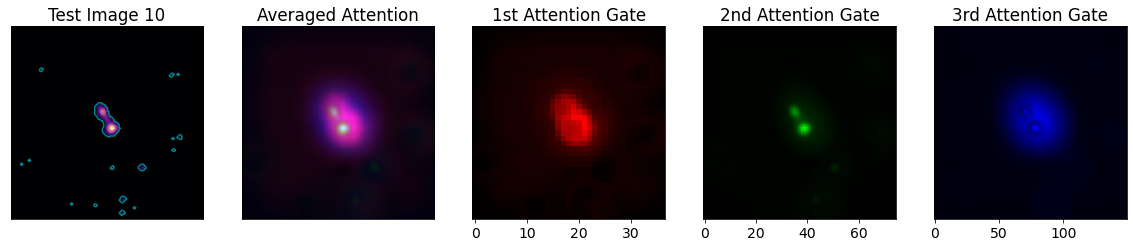

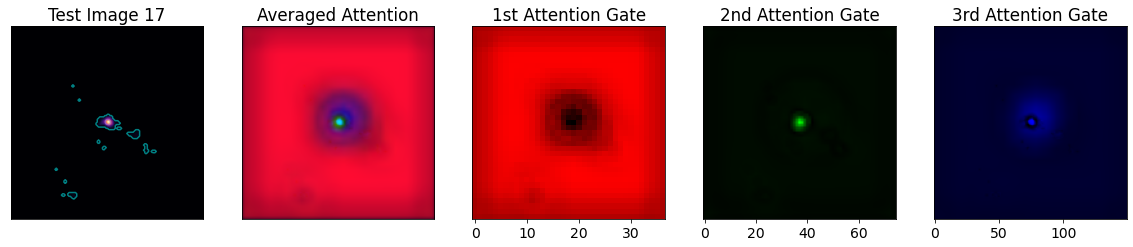

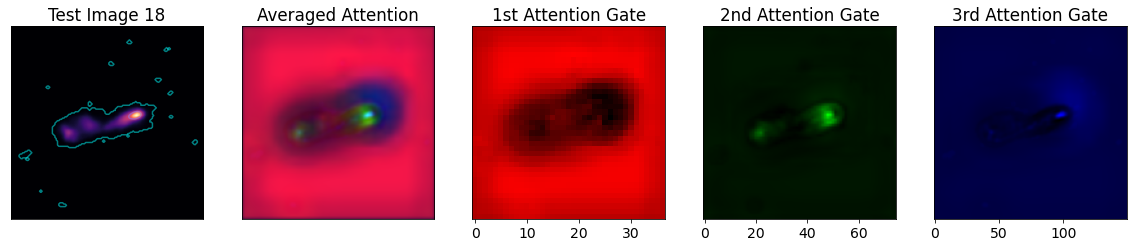

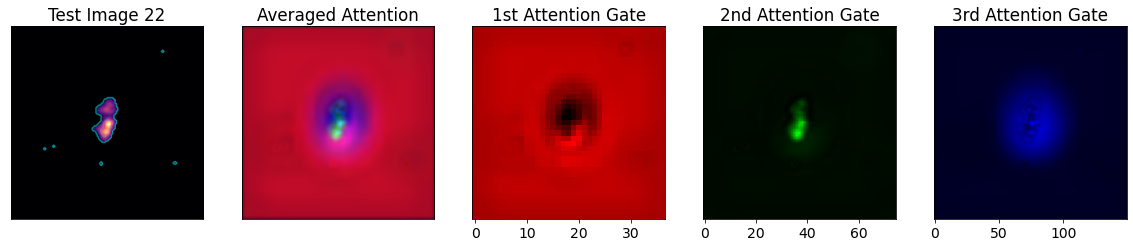

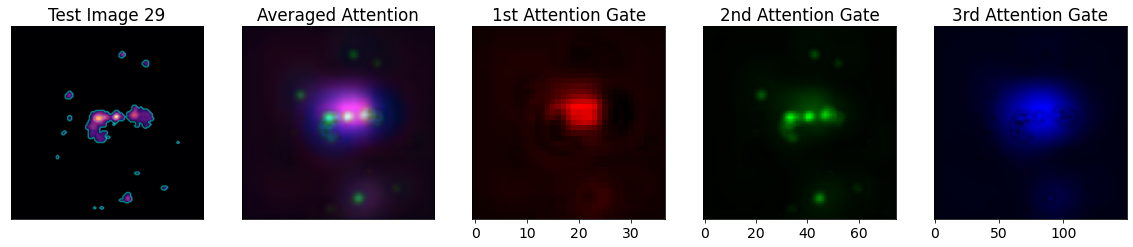

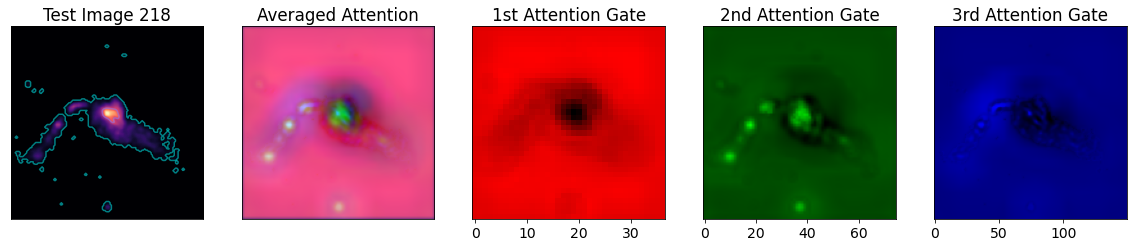

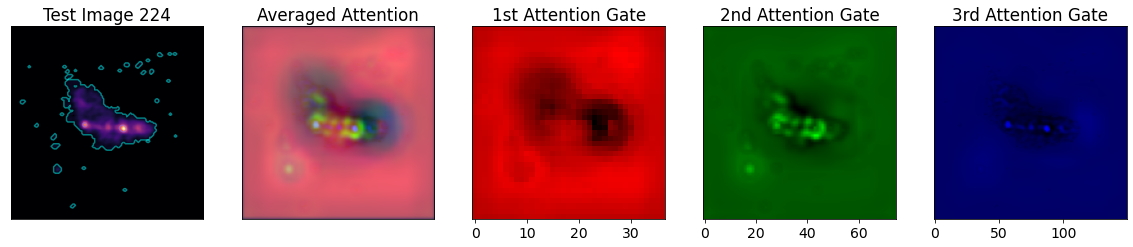

configs/e2attentionmirabest-RandAug.cfg
Files already downloaded and verified


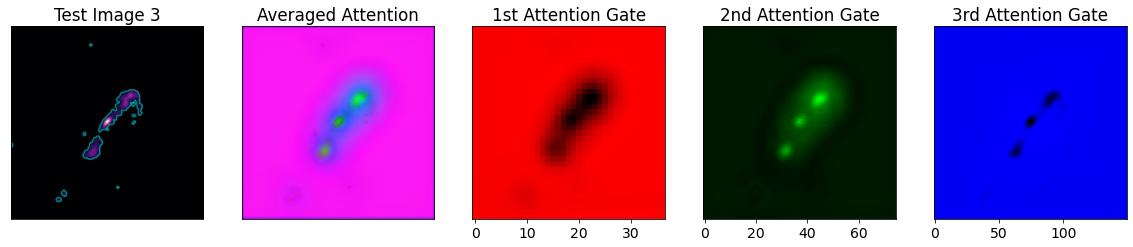

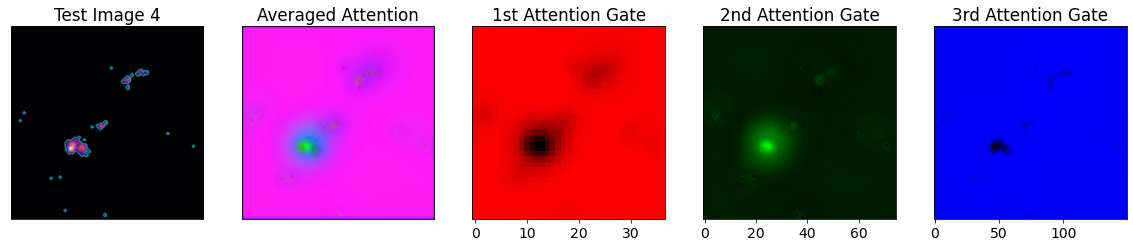

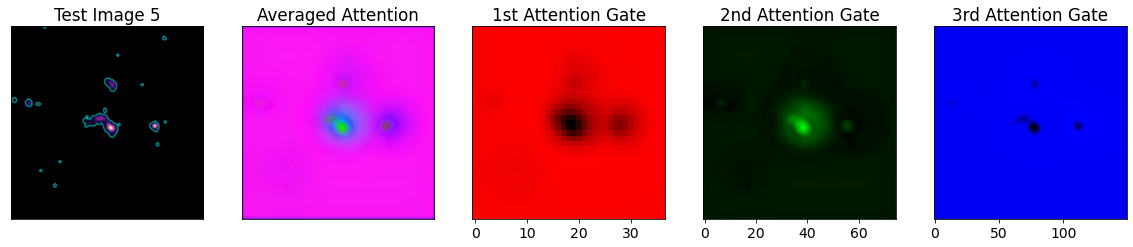

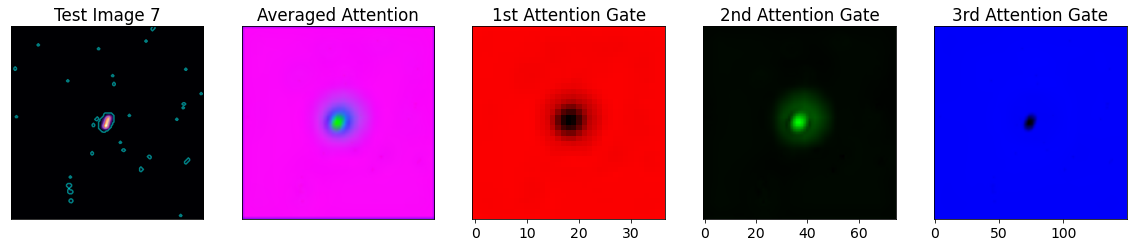

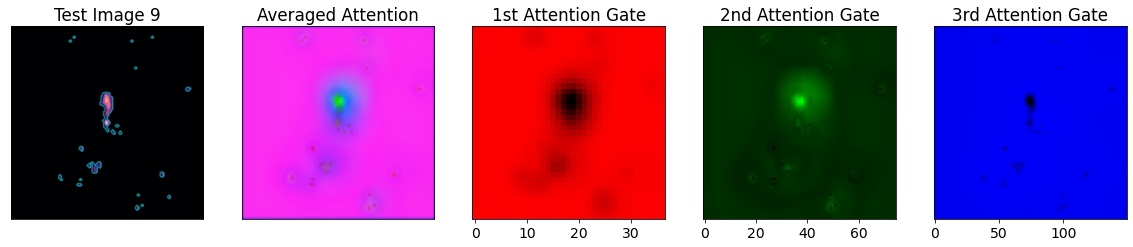

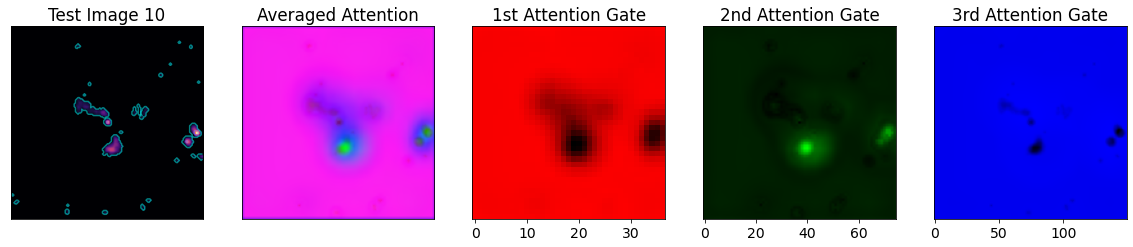

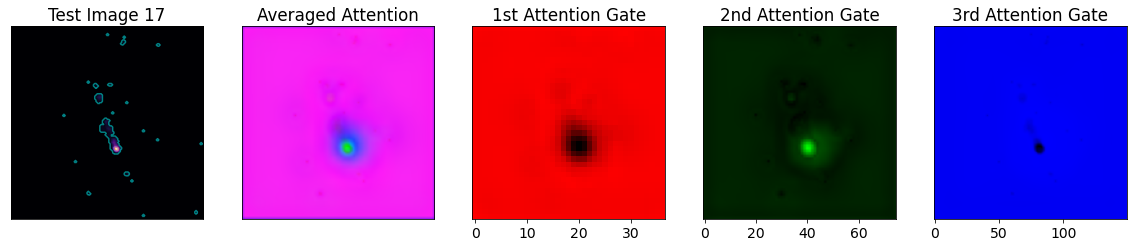

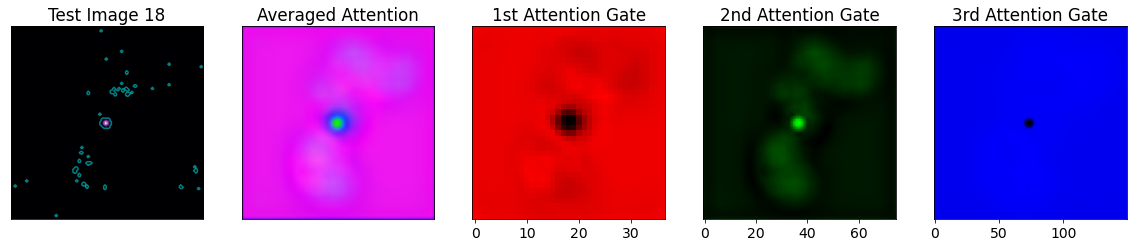

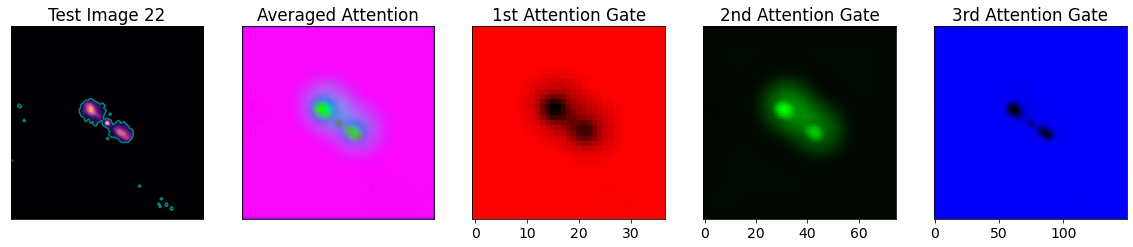

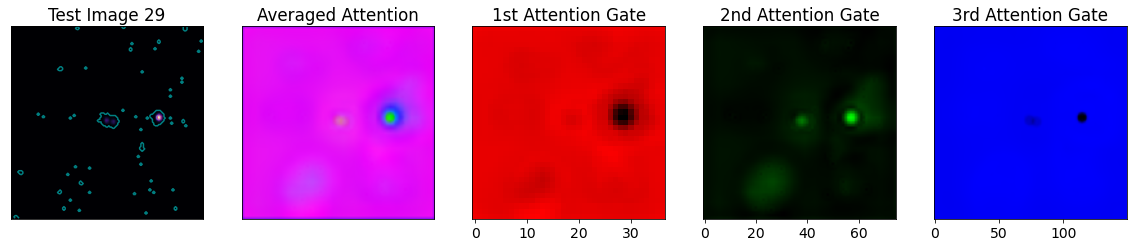

In [14]:
config_names = [
    #"bowles2021mirabest.cfg",
    #"scaife2021mirabest.cfg",
    "e2attentionmirabest.cfg",
    
    #"bowles2021mingo.cfg",
    #"scaife2021mingo.cfg", 
    "e2attentionmingo.cfg",
    
    "e2attentionmirabest-RandAug.cfg"
]

#plot = 'all'
plot = [3, 4, 5, 7, 9, 10, 17, 18, 22, 29]

for config_name in config_names:
    if 'mingo' in config_name and type(plot)==list:
        plot+=[218, 224]
        
    config_name = "configs/"+config_name
    print(config_name)
    config = ConfigParser.ConfigParser(allow_no_value=True)
    config.read(config_name)
    
    imap, fmap, test_data, predictions = source_attention(config, path_supliment="", plot=plot, fontsize=14, RGB=True, device=device)
    if 'mingo' in config_name and type(plot)==list:
        plot = plot[:-2]